In [1]:
import os
from datetime import datetime

from collections import namedtuple
from enum import Enum

from PIL import Image

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import random
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display
from tqdm import tqdm

import cv2
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam, SGD

# Practica 2
Prats Guasch, Víctor Antonio

## 1. Problema a resoldre
En aquesta segona pràctica es demana crear una xarxa neuronal capaç de discriminar entre gossos i gats. La xarxa desenvolupada s'ha de comparar amb una xarxa ja existent, reentrenada amb les dades donades. S'ha dedicit implementar també la classificació de les races de les diferents mascotes, a partir d'una xarxa estandarditzada.

Per a resoldre el problema, serà necessari seguir els següents passos:

1. Anàlisi del conjunt de dades donat
2. Creació del dataset, aplicació d'estrategies de data augmentation (si aplica)
3. Creació, entrenament i validació de diferents xarxes per resoldre el problema
4. Millora de la xarxa trobada al punt anterior

## 2. Anàlisi del conjunt de dades
El conjunt de dades proporcionat conté un fitxer anomenat `list.txt` que enumera totes les imatges del conjunt de dades, juntament amb el seu identificador de "classe" (o raça en el nostre context) i l'espècie (1: Gat o 2: Gos). Per a treballar amb les dades, llegirem primer aquest fitxer i crearem un conjunt d'entrenament i de test a partir de les imatges enumerades, el que ens permetrà determinar la categoria objectiu a partir de cadascuna de línies llegides. Abans de continuar, és necessari verificar si `list.txt` conté totes les imatges presents a la carpeta `/images/` del conjunt de dades.

In [2]:
class AugmentationStrategy(Enum):
    NONE = 0
    ROTATE_RIGHT = 1
    ROTATE_LEFT = 2

# Cream les clases que representen cada tupla de elements (image_path, label, augmentation, args)
DataPoint = namedtuple("DataPoint", ["image_path", "label", "augmentation", "arg0"])

dataset_base_path = "../../PetDataset/"

def split_list(lines, left_percentage = 0.5):
    random_indices = random.sample(range(len(lines)), int(len(lines) * left_percentage))
    
    random_subset = [lines[i] for i in random_indices]
    remaining_elements = [elem for idx, elem in enumerate(lines) if idx not in random_indices]
    
    return random_subset, remaining_elements

def data_augment_cats(data_points):
    new_data_points = [DataPoint(point.image_path, point.label, AugmentationStrategy.ROTATE_RIGHT, 5) 
                           for point in data_points if point.label == 0]
    return data_points + new_data_points

with open(f"{dataset_base_path}/annotations/list.txt") as f:
    all_data = []
    for line in f.readlines()[6:]:    
        line = line.strip().split(' ')
        
        image_path = line[0]
        # Take the species from the annotations, and substract 1 to treat it as a category
        label = int(line[2]) - 1
        all_data.append(DataPoint(image_path, label, AugmentationStrategy.NONE, None))

In [3]:
# Verificam si totes les imatges estan presents a /images/
images_in_list = sorted([point.image_path for point in all_data])
images_in_dataset = sorted([img.replace(".jpg", "") for img in os.listdir(f"{dataset_base_path}/images/") if img.endswith(".jpg")])

not_in_dataset = [x for x in images_in_list if x not in images_in_dataset]
not_in_list = [x for x in images_in_dataset if x not in images_in_list]

print(f"Imatges a la llista i no en el conjunt de dades: {not_in_dataset}")
print(f"Imatges en el conjunt de dades i no a la llista: {not_in_list}")

Imatges a la llista i no en el conjunt de dades: []
Imatges en el conjunt de dades i no a la llista: ['Abyssinian_34', 'Abyssinian_82', 'Bombay_11', 'Bombay_189', 'Bombay_190', 'Bombay_192', 'Bombay_203', 'Bombay_206', 'Bombay_209', 'Bombay_210', 'Bombay_217', 'Bombay_22', 'Bombay_220', 'Bombay_32', 'Bombay_69', 'Bombay_85', 'Bombay_92', 'Bombay_99', 'Egyptian_Mau_129', 'Egyptian_Mau_139', 'Egyptian_Mau_145', 'Egyptian_Mau_167', 'Egyptian_Mau_177', 'Egyptian_Mau_183', 'Egyptian_Mau_191', 'Egyptian_Mau_202', 'Egyptian_Mau_41', 'Egyptian_Mau_71', 'Siamese_203', 'boxer_82', 'english_cocker_spaniel_162', 'english_cocker_spaniel_163', 'english_cocker_spaniel_164', 'english_cocker_spaniel_179', 'keeshond_59', 'newfoundland_152', 'newfoundland_153', 'newfoundland_154', 'newfoundland_155', 'staffordshire_bull_terrier_2', 'staffordshire_bull_terrier_22']


Com podem veure, algunes imatges del conjunt no estan incloses en el fitxer `list.txt`. Això pot ser degut al fet que varen ser incloses o actualitzades després de la publicació del *paper* associat a les dades, per a solucionar-ho, les afegim de manera manual a la llista.

In [4]:
for image_to_add in not_in_list:
    label = int(image_to_add[0].islower())
    all_data.append(DataPoint(image_to_add, label, AugmentationStrategy.NONE, None))

In [5]:
balanced_class_data = data_augment_cats(all_data)

# 70% train, 10% validation, 20% test
train_data, test_data = split_list(balanced_class_data, left_percentage=0.8)
train_data, validation_data = split_list(train_data, left_percentage=0.85)

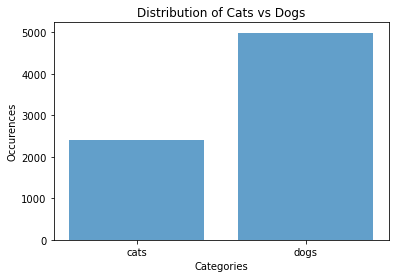

In [6]:
def count_cats_and_dogs(data_points) -> dict:
    result = {"cats": 0, "dogs": 0}

    for data_point in data_points:
        if data_point.label == 0:
            result["cats"] += 1
        else:
            result["dogs"] += 1
            
    return result

base_subset_counts = count_cats_and_dogs(all_data)

plt.bar(base_subset_counts.keys(), base_subset_counts.values(), align='center', alpha=0.7)
plt.title("Distribution of Cats vs Dogs")
plt.xlabel("Categories")
plt.ylabel("Occurences")
plt.show()

Tal com es presenta, la nostra categoria objectiu no està balancejada. Per a solucionar aquest problema, s'han fet servir tècniques de data augmentation, totes les imatges de gats seran duplicades i girades 5 graus en sentit horari. Aquesta mateixa implementació serà útil per provar el rendiment del model sobre més dades d'entrenament.

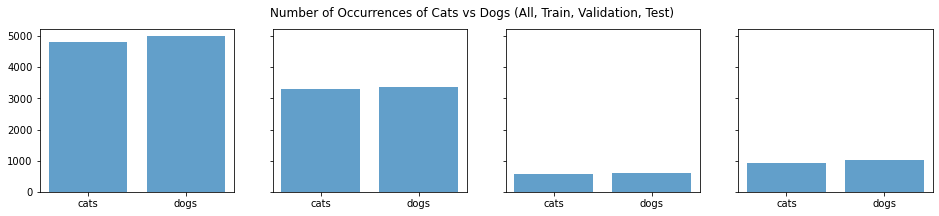

In [7]:
base_subset_counts_balanced = count_cats_and_dogs(balanced_class_data)
base_subset_counts_train = count_cats_and_dogs(train_data)
base_subset_counts_val = count_cats_and_dogs(validation_data)
base_subset_counts_test = count_cats_and_dogs(test_data)

fig, axs = plt.subplots(1, 4, figsize=(16, 3), sharey=True)
axs[0].bar(base_subset_counts_balanced.keys(), base_subset_counts_balanced.values(), align='center', alpha=0.7)
axs[1].bar(base_subset_counts_train.keys(), base_subset_counts_train.values(), align='center', alpha=0.7)
axs[2].bar(base_subset_counts_val.keys(), base_subset_counts_val.values(), align='center', alpha=0.7)
axs[3].bar(base_subset_counts_test.keys(), base_subset_counts_test.values(), align='center', alpha=0.7)
fig.suptitle('Number of Occurrences of Cats vs Dogs (All, Train, Validation, Test)')
plt.show()

Com podem veure, els conjunts d'entrenament i de proves mantenen el mateix rati d'ocurrències de gossos i gats, que és aproximadament igual. Podem ara preparar el dataset a partir de les dades generades anteriorment, tot i això, verificarem que la categoria extreta sigui la correcta per alguns exemples.

In [8]:
for data_point in balanced_class_data:
    expected_label = int(data_point.image_path[0].islower())
    if data_point.label != expected_label:
        print(f"ERROR: Expected: {expected_label}, got: {data_point.label}")

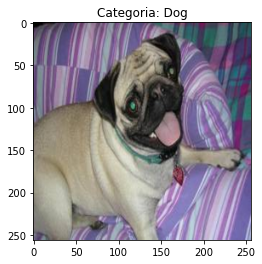

In [9]:
# Seleccionam una linia aleatoria d'entrenament i verificam l'extracció de l'espècie objectiu
species_dict = {0: "Cat", 1: "Dog"}

random.seed(42)
selected_data = train_data[random.randint(0, len(train_data))]

img = Image.open(f"{dataset_base_path}/images/{selected_data.image_path}.jpg")
img = img.convert("RGB")

plt.imshow(img.resize(size = (256, 256)))
plt.title(f"Categoria: {species_dict[selected_data.label]}")
plt.show()

## 2.1 Creació del dataset i mètodes d'utilitat

Una vegada conclòs l'anàlisi de les dades, es procedeix a la creació d'una classe `PetDataset`, que recollirà les imatges a processar i la seva etiqueta esperada. A més, s'aplicaran les tècniques de data augmentation indicades i es normalitzarà la imatge resultant segons la mitjana i desviació estàndard de cada canal de color.

[Aquesta normalització és important](https://stackoverflow.com/questions/4674623/why-do-we-have-to-normalize-the-input-for-an-artificial-neural-network/), ja que els valors de la funció de pèrdua creixen segons els dominis de cada una de les característiques usades per optimitzar, el que pot generar salts difícils de resoldre. La normalització genera una funció més simètrica i senzilla, per la qual cosa es poden fer servir tasses d'aprenentatge més elevades si així es desitja.

Pel que fa als valors usats per a la normalització, per norma general es poden seguir dues estratègies:

* Emprar valors ja computats d'un dataset més gran amb característiques similars a les imatges
* Calcular els valors segons les imatges del conjunt de dades amb el qual s'està tractant

La següent [discussió](https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670) entra més en detall en les raons per les quals cadascun d'aquests mètodes pot ser útil. En resum, emprar els pesos d'un dataset més gran i similar, com podria ser ImageNet en el nostre cas pot servir com a bon punt de partida i a més generalitzar de millor manera, ja que conté molts més exemples. Per altra banda, els valors sempre s'han de recalcular per conjunts de dades molt diferents del més gran, o en cas que es vulgui aconseguir la màxima precisió. En aquest cas s'ha optat per aquesta metodologia per completitud i per ajudar a entendre el càlcul dels valors en diferents dimensionalitats.

In [17]:
class PetDataset(Dataset):
    def __init__(self, data_points, transform=None):
        super().__init__()
        self.data_points = data_points
        self.len = len(self.data_points)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        data_point = self.data_points[index]
        image = Image.open(f"{dataset_base_path}/images/{data_point.image_path}.jpg")
        image = image.convert("RGB")
        image = self.__apply_data_augmentation(image, data_point)
        
        label = data_point.label
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label
    
    def __apply_data_augmentation(self, image, data_point):
        if data_point.augmentation == AugmentationStrategy.NONE:
            return image
        elif data_point.augmentation == AugmentationStrategy.ROTATE_RIGHT:
            return image.rotate(abs(data_point.arg0))
        elif data_point.augmentation == AugmentationStrategy.ROTATE_LEFT:
            return image.rotate(-abs(data_point.arg0))
        else:
            raise NotImplementedError("Unhandled data augmentation technique")
    
mean = [0.4777, 0.4439, 0.3941]
std = [0.2316, 0.2277, 0.2290]
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((256, 256), antialias=True),
        transforms.Normalize(mean=mean, std=std),
    ]
)

train_ds = PetDataset(train_data, transform)
# https://stackoverflow.com/questions/56576716/pytorch-dataloader-fails-when-the-number-of-examples-are-not-exactly-divided-by
train_dl = DataLoader(train_ds, batch_size=64, drop_last=True)
train_dl.dataset[0][0].shape, train_dl.dataset[0][1]

(torch.Size([3, 256, 256]), 0)

In [29]:
mean, std = 0.0, 0.0
num_samples = len(train_ds)

for data, _ in tqdm(train_ds, total=num_samples):
    mean += data.mean(dim=(1, 2))
    std += data.std(dim=(1, 2))

mean /= num_samples
std /= num_samples

print("Mean:", mean)
print("Std:", std)

100%|█████████████████████████████████████████████████████████████████████████████| 4895/4895 [00:20<00:00, 241.37it/s]

Mean: tensor([0.4777, 0.4439, 0.3941])
Std: tensor([0.2316, 0.2277, 0.2290])


In [18]:
val_ds = PetDataset(validation_data, transform)
val_dl = DataLoader(val_ds, batch_size=64, drop_last=True)
val_dl.dataset[0][0].shape, val_dl.dataset[0][1]

(torch.Size([3, 256, 256]), 1)

In [19]:
test_ds = PetDataset(test_data, transform)
test_dl = DataLoader(test_ds, batch_size=64, drop_last=True)
test_dl.dataset[0][0].shape, test_dl.dataset[0][1]

(torch.Size([3, 256, 256]), 0)

Una vegada creats els datasets, podem passar als experiments. En aquest punt es dissenyaran, entrenaran i avaluaran diferents xarxes sobre els conjunts d'entrenament i validació. Posteriorment, s'avaluarà la millor xarxa contra el conjunt de test, per verificar el seu rendiment sobre dades desconegudes.

## 3. Experiments

Definirem primer tots els mètodes d'utilitat necessaris per a l'entrenament i avaluació de la xarxa, de manera que puguin ser reutilitzats entre els diferents experiments.

In [20]:
torch.manual_seed(33)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, optim, criterion, train_loader, val_loader, epochs=40, extra_save_info=""):
    model = model.to(device)
    
    t_loss = np.zeros((epochs))
    v_loss = np.zeros((epochs))

    pbar = tqdm(range(1, epochs+1))

    for epoch in pbar:
        train_loss = 0
        val_loss = 0

        model.train()                                                  
        for batch_num, (input_img, target) in enumerate(train_loader, 1):   
            input_img= input_img.to(device)
            target = target.to(device)

            output = model(input_img)

            loss = criterion(output, target)
            loss.backward()
            optim.step()
            optim.zero_grad()

            train_loss += loss.item()

        model.eval()   
        with torch.no_grad():                                          
            for input_img, target in val_loader:
                input_img = input_img.to(device)
                target = target.to(device)

                output = model(input_img)
                loss = criterion(output, target)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        t_loss[epoch-1] = train_loss

        val_loss /= len(val_loader)   
        v_loss[epoch-1] = val_loss

        plt.figure(figsize=(12, 4))
        pl.plot(t_loss[:epoch], label="train")
        pl.plot(v_loss[:epoch], label="validation")
        pl.legend()
        pl.xlim(0, epochs)
        pl.xticks(range(0,epochs,1),range(1,epochs+1,1))

        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.close()

        pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")
        
    torch.save(model.state_dict(), f"{model.__class__.__name__}-{epochs}-epochs-{extra_save_info}-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pt")

    return model

def evaluate_performance(model, test_dataloader):
    model.eval()

    targets = []
    predictions = []

    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            targets.extend(target.tolist())
            predictions.extend(torch.flatten(pred.cpu()).tolist())

    targets = np.asarray(targets)
    predictions = np.asarray(predictions)

    cm = confusion_matrix(targets, predictions)

    classes = ["cat", "dog"]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prediction")
    plt.ylabel("Ground Truth")
    plt.title(f"Confusion matrix, model accuracy: {accuracy_score(targets, predictions)}")
    plt.show()

epochs = 40
criterion = nn.CrossEntropyLoss(reduction="sum")

### 3.1 VGG reduïda

Aquest primer experiment busca crear una versió simplificada de la [VGG](https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide), substituint les capes fully connected per una darrera convolució i max pooling, a fi de reduir més les dimensions de la imatge. Finalment, es redueix el nombre de canals al nombre de categories desitjades i s'aplica un `AdaptativeAvgPool2D`. Aquesta capa calcularà la mitja en cada una de les convolucions aplicades, de manera similar a com `MaxPool2d` ho fa amb el màxim. La principal diferència apareix en els seus paràmetres, en lloc d'indicar la mida del kernel, indicam la mida de sortida desitjat i el mètode s'encarrega de calcular la dimensió necessària, en aquest cas, buscam una sortida de mida 1. S'ha emprat un `AvgPool` perquè buscam la probabilitat de cada classe, de manera similar a com ho fa el softmax (donant probabilitats que sumen 1 en la seva totalitat).

In [21]:
class SmallVGG(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallVGG, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64x64
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=1),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x).squeeze()
        return x

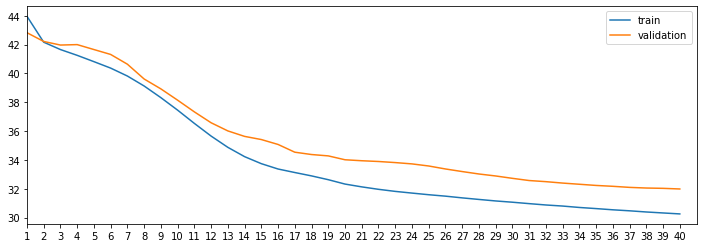

Epoch:40 Training Loss:30.257729310255783 Validation Loss:31.98746246761746: 100%|█████| 40/40 [41:34<00:00, 62.36s/it]


In [22]:
model = SmallVGG(num_classes=2)

optim = Adam(model.parameters(), lr=1e-4)
model = train(model, optim, criterion, train_dl, val_dl, epochs)

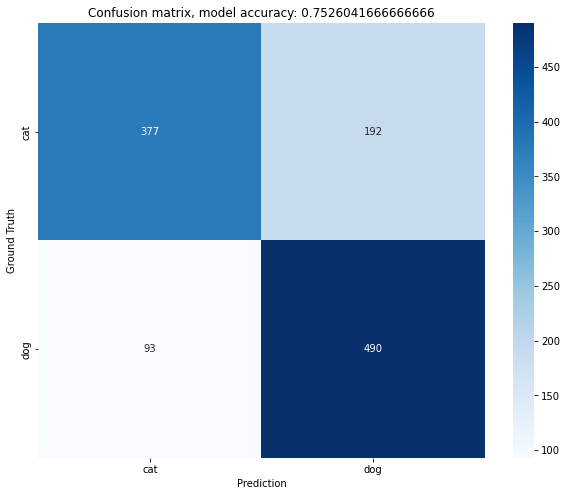

In [23]:
evaluate_performance(model, val_dl)

Com podem veure, la xarxa té un rendiment acceptable però lluny de l'òptim. A partir de l'epoch 20, el guany és negligible el que pot indicar que les característiques extretes no són prou significatives o que la xarxa no és capaç de realitzar una bona classificació sense la capa fully connected.

### 3.2 VGG reduïda amb 3 capes

A fi de millorar la xarxa anterior, afegirem una tercera capa d'extracció de característiques. D'aquesta manera podrem determinar si el problema són les característiques extretes o la falta d'un classificador més elaborat.

In [26]:
class SmallVGG3Layers(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallVGG3Layers, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32x128
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x).squeeze()
        return x

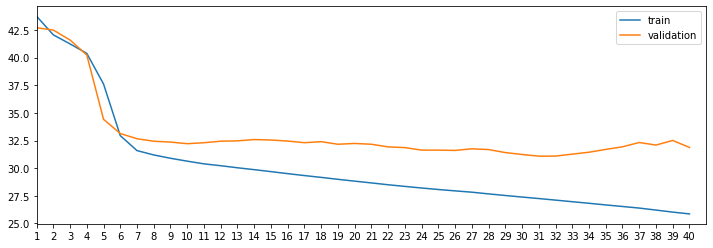

Epoch:40 Training Loss:25.858843399928165 Validation Loss:31.873307863871258: 100%|█| 40/40 [3:00:24<00:00, 270.60s/it]


In [27]:
model = SmallVGG3Layers(num_classes=2)
    
optim = Adam(model.parameters(), lr=1e-4)
model = train(model, optim, criterion, train_dl, val_dl, epochs)

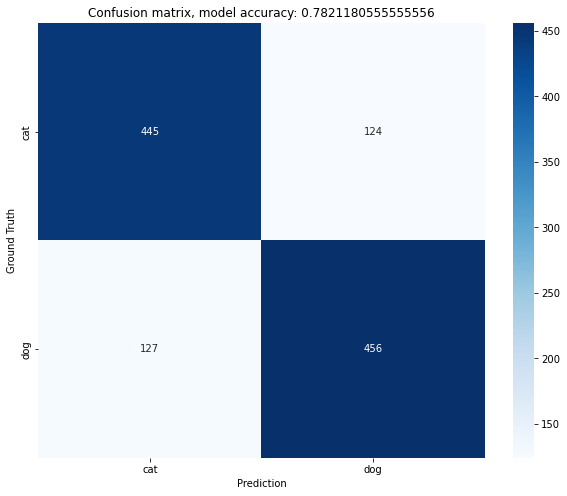

In [28]:
evaluate_performance(model, val_dl)

Observant la matriu de confusió podem veure que les prediccions són molt més homogènies i ja equitatives entre gossos i gats. Això ens pot indicar que l'extracció de característiques ha millorat, però encara es requereix l'ús d'un classificador més complex.

### 3.3 VGG reduïda amb classificador fully connected

Partint del model amb 3 blocs d'extracció de característiques, afegim una darrera capa convolucional seguida d'un max pooling per reduir el nombre de neurones a la capa fully connected que s'ha afegit. Aquesta tindrà dues capes ocultes, i s'anirà reduint el nombre de neurones gradualment fins a arribar a un nombre proper a les classes objectiu.

In [29]:
class SmallVGGFC(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallVGGFC, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32x128
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 16 * 256, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
model = SmallVGGFC(num_classes=2)

optim = Adam(model.parameters(), lr=1e-4)
model = train(model, optim, criterion, train_dl, val_dl, epochs)

In [ ]:
evaluate_performance(model, val_dl)

In [ ]:
class SmallVGGFCNoHidden(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallVGGFCNoHidden, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32x128
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 16 * 256, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

In [ ]:
model = SmallVGGFCNoHidden(num_classes=2)

optim = Adam(model.parameters(), lr=1e-4)
model = train(model, optim, criterion, train_dl, val_dl, epochs)

In [ ]:
evaluate_performance(model, val_dl)

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout2d(p=0.25)
        
        self.fc = nn.Linear(in_features=32 * 32 * 64, out_features=num_classes)

    def forward(self, x):
                                             # Inici: 256x256x3
        x = F.relu(self.pool(self.conv1(x))) # 128x128x16
        x = F.relu(self.pool(self.conv2(x))) # 64x64x32
        x = F.relu(self.pool(self.conv3(x))) # 32x32x32
        x = F.relu(self.drop(self.conv4(x))) # 32x32x64
        
        x = F.dropout(x, training=self.training)
        
        x = x.view(-1, 32 * 32 * 64)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = SmallCNN(num_classes=2)

optim = Adam(model.parameters(), lr=1e-4)
model = train(model, optim, criterion, train_dl, val_dl, epochs)

In [ ]:
evaluate_performance(model, test_dl)

In [ ]:
class SmallCNN6Layers(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallCNN6Layers, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout2d(p=0.25)
        
        self.fc = nn.Linear(in_features=8 * 8 * 128, out_features=num_classes)

    def forward(self, x):
                                             # Inici: 256x256x3
        x = F.relu(self.pool(self.conv1(x))) # 128x128x16
        x = F.relu(self.pool(self.conv2(x))) # 64x64x32
        x = F.relu(self.pool(self.conv3(x))) # 32x32x32
        x = F.relu(self.pool(self.conv4(x))) # 16x16x64
        x = F.relu(self.pool(self.conv5(x))) # 8x8x64
        x = F.relu(self.drop(self.conv6(x))) # 8x8x128

        
        x = F.dropout(x, training=self.training)
        
        x = x.view(-1, 8 * 8 * 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = SmallCNN6Layers(num_classes=2)

optim = Adam(model.parameters(), lr=1e-4)
model = train(model, optim, criterion, train_dl, val_dl, epochs)

In [ ]:
evaluate_performance(model, val_dl)

In [ ]:
class SmallCNN6LayersHidden(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallCNN6LayersHidden, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout2d(p=0.25)
        
        self.fc = nn.Linear(in_features=8 * 8 * 128, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)

    def forward(self, x):
                                             # Inici: 256x256x3
        x = self.pool(F.relu(self.conv1(x))) # 128x128x16
        x = self.pool(F.relu(self.conv2(x))) # 64x64x32
        x = self.pool(F.relu(self.conv3(x))) # 32x32x32
        x = self.pool(F.relu(self.conv4(x))) # 16x16x64
        x = self.pool(F.relu(self.conv5(x))) # 8x8x64
        x = self.drop(F.relu(self.conv6(x))) # 8x8x128
        
        x = F.dropout(x, training=self.training)
        
        x = x.view(-1, 8 * 8 * 128)
        x = F.dropout(F.relu(self.fc(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = SmallCNN6LayersHidden(num_classes=2)

optim = Adam(model.parameters(), lr=1e-4)
model = train(model, optim, criterion, train_dl, val_dl, epochs)

In [ ]:
evaluate_performance(model, val_dl)

## Evaluació

In [52]:
# Carregam el model desitjat

#model = SmallCNN6LayersHidden(num_classes=2).to(device)
#model.load_state_dict(torch.load("smallcnn6layershidden-40-epochs.pt"))

<All keys matched successfully>

In [53]:
#evaluate_test_performace(model, test_dl)

Accuracy: 0.8602880658436214


# Comparació de la xarxa desenvolupada amb AlexNet

In [18]:
alex_model = models.alexnet(weights=None)

# Reduim el nombre de neurones de manera gradual, ja que tenim 2 categories objectiu
alex_model.classifier[1] = nn.Linear(in_features=9216, out_features=2048)
alex_model.classifier[4] = nn.Linear(in_features=2048, out_features=1024)
alex_model.classifier[6] = nn.Linear(in_features=1024, out_features=2)
print(alex_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)
 

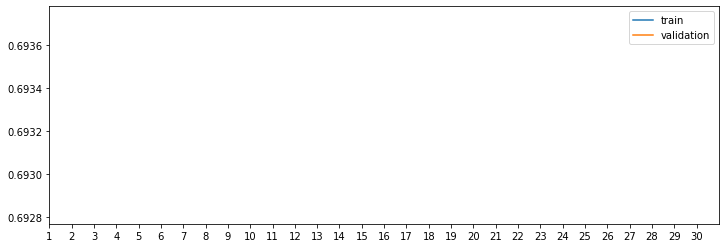

Epoch:1 Training Loss:0.692812857173738 Validation Loss:0.6937357061787656:   3%|▏      | 1/30 [00:51<25:07, 51.99s/it]


KeyboardInterrupt: 

In [19]:
epochs = 30
optim = SGD(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss(reduction="mean")

alex_model = train(alex_model, optim, criterion, train_dl, val_dl, epochs)

In [ ]:
evaluate_performance(alex_model, test_dl)

## I si fem servir els pesos de cataracteristiques preentrenats?

In [7]:
alex_model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1")

# Reduim el nombre de neurones de manera gradual, ja que tenim 2 categories objectiu
alex_model.classifier[1] = nn.Linear(in_features=9216, out_features=2048)
alex_model.classifier[4] = nn.Linear(in_features=2048, out_features=1024)
alex_model.classifier[6] = nn.Linear(in_features=1024, out_features=2)
print(alex_model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Victor/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|███████████████████████████████████████████████████████████████████████████████| 233M/233M [00:04<00:00, 53.3MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)
 

In [ ]:
epochs = 30
optim = SGD(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss(reduction="mean")

alex_model = train(alex_model, optim, criterion, train_dl, val_dl, epochs)

In [ ]:
evaluate_performance(alex_model, test_dl)